In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def clean_colnames(colname):
    cleaned_colname = colname.lower()
    cleaned_colname = re.sub(r'\W+', '_', cleaned_colname)
    return cleaned_colname

In [4]:
loan_df = pd.read_excel('C:/Users/USER/Downloads/LoanHistoricalData.xlsx')
loan_df.columns = [clean_colnames(colname) for colname in loan_df.columns]
loan_df = loan_df.drop(columns=['loan_ids'], axis=1)
print(loan_df.shape)
print(loan_df.columns)
loan_df.head(3)

(6000, 20)
Index(['good_bad_loan', 'covid_period_default_', 'recomended_loan_amt',
       'interest_rate', 'tenor', 'total_collateral_value', 'rec_basis',
       'fresh_topup', 'product', 'constitution', 'source_branch',
       'applicant_state', 'applicant_city', 'coborrower1_designation',
       'coborrower2_designation', 'coborrower1_cibilscore',
       'coborrower2_cibilscore', 'locality', 'years_of_operation',
       'total_income'],
      dtype='object')


,good_bad_loan,covid_period_default_,recomended_loan_amt,interest_rate,tenor,total_collateral_value,rec_basis,fresh_topup,product,constitution,source_branch,applicant_state,applicant_city,coborrower1_designation,coborrower2_designation,coborrower1_cibilscore,coborrower2_cibilscore,locality,years_of_operation,total_income
0,Bad,Yes,51055,14,35,NaN,Cashflows,Fresh,Unsecured,Trust,A,New Jersey,Nguyenberg,Chairman,Secretary,866.0,-1.0,SEMIU,8,8.607574e+06
1,Good,No,71357,14,43,2.826936e+07,Finance Ledgers,Fresh,Secured,Society,B,Maine,North Jimmyshire,Secretary,Trustee,866.0,368.0,RURAL,8,9.628977e+06
2,Bad,Yes,4127836,14,110,NaN,Cashflows,Fresh,Others,Society,C,Louisiana,Myersmouth,Managing Director,Trustee,566.0,862.0,RURAL,30,6.504837e+07


In [5]:
(
    loan_df
    .isnull()
    .sum()
    .rename('missing_freq')
    .sort_values(ascending=False)
    .loc[lambda x: x>0]
    .reset_index()
    .rename(columns={'index': 'colname'})
    .assign(missing_per=lambda x: (x['missing_freq']/loan_df.shape[0])*100)
)

,colname,missing_freq,missing_per
0,total_collateral_value,3729,62.150000
1,coborrower1_designation,51,0.850000
2,total_income,42,0.700000
3,coborrower2_cibilscore,31,0.516667
4,coborrower2_designation,28,0.466667
5,rec_basis,3,0.050000
6,coborrower1_cibilscore,1,0.016667
7,applicant_city,1,0.016667


In [6]:
loan_df['total_collateral_value'] = loan_df['total_collateral_value'].fillna(0)
loan_df = loan_df.dropna()

In [7]:
(
    loan_df
    .isnull()
    .sum()
    .rename('missing_freq')
    .sort_values(ascending=False)
    .loc[lambda x: x>0]
    .reset_index()
    .rename(columns={'index': 'colname'})
    .assign(missing_per=lambda x: (x['missing_freq']/loan_df.shape[0])*100)
)

,colname,missing_freq,missing_per


In [8]:
loan_df.nunique().rename('unique_count').sort_values(ascending=False)

total_income               5845
recomended_loan_amt        5826
applicant_city             4918
total_collateral_value     2223
coborrower2_cibilscore      586
coborrower1_cibilscore      580
tenor                       121
years_of_operation           61
applicant_state              50
source_branch                45
coborrower1_designation      13
coborrower2_designation      13
constitution                  6
rec_basis                     5
product                       3
locality                      3
covid_period_default_         2
fresh_topup                   2
good_bad_loan                 2
interest_rate                 1
Name: unique_count, dtype: int64

In [9]:
designation_order = ['CHAIRMAN', #0
 'PRESIDENT',
 'MANAGING DIRECTOR',
 'VICE PRESIDENT',
 'DIRECTOR',
 'SECRETARY',
 'TREASURER',
 'MANAGING TRUSTEE',
 'COMMITTEE MEMBER',
 'MEMBER',
 'TRUSTEE',
 'CORRESPONDENT',
 'OTHERS'] #weightage
designation_mapping = {designation: i for i, designation in enumerate(designation_order)}
loan_df['coborrower1_designation_ordinal'] = loan_df['coborrower1_designation'].str.upper().map(designation_mapping)
loan_df['coborrower2_designation_ordinal'] = loan_df['coborrower2_designation'].str.upper().map(designation_mapping)

loan_df['covid_period_default_'] = loan_df['covid_period_default_'].replace({'Yes': 1, 'No': 0})
loan_df['fresh_topup'] = loan_df['fresh_topup'].replace({'Fresh': 0, 'Top Up': 1})
loan_df['good_bad_loan'] = loan_df['good_bad_loan'].replace({'Bad': 1, 'Good': 0})

loan_df = loan_df.drop(columns=['interest_rate', 'coborrower1_designation', 'coborrower2_designation'], axis=1)

In [10]:
# Frequency encoding for 'applicant_city'
freq_encoding = loan_df.groupby('applicant_state').size() / len(loan_df)
loan_df['applicant_state'] = loan_df['applicant_state'].map(freq_encoding)

In [11]:
city_income_encoding = (loan_df.groupby('applicant_city')['total_income'].mean()/loan_df.groupby('applicant_city').size()).to_dict()
loan_df['applicant_city'] = loan_df['applicant_city'].map(city_income_encoding)

In [12]:
weighted_income_dict = (
    loan_df
    .groupby('source_branch')
    .agg(
        mean_income=('total_income', 'mean'),
        count_income=('total_income', 'size')
    )
    .assign(
        weighted_income=lambda x: (x['mean_income']/x['count_income'])*100
    )
    .loc[:, 'weighted_income']
    .to_dict()
)

loan_df['source_branch'] = loan_df['source_branch'].map(weighted_income_dict)

In [13]:
modeling_df = pd.get_dummies(loan_df, columns=['constitution', 'rec_basis', 'product', 'locality'], drop_first=True, dtype=int)

In [14]:
modeling_df.shape

(5845, 28)

In [15]:
X = modeling_df.drop(columns=['good_bad_loan'], axis=1)
Y = modeling_df['good_bad_loan']

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(4091, 27) (1754, 27) (4091,) (1754,)


In [17]:
Y_train.value_counts(), Y_test.value_counts()

(good_bad_loan
 1    2152
 0    1939
 Name: count, dtype: int64,
 good_bad_loan
 1    909
 0    845
 Name: count, dtype: int64)

In [18]:
categorical_cols = [
    'constitution_Partnership / LLP',
       'constitution_Private Limited Company',
       'constitution_Public Limited Company', 'constitution_Society',
       'constitution_Trust', 'rec_basis_Bank Credits', 'rec_basis_Cashflows',
       'rec_basis_Finance Audits', 'rec_basis_Finance Ledgers',
       'product_Secured', 'product_Unsecured', 'locality_SEMIU',
       'locality_URBAN', 'fresh_topup','covid_period_default_',
    'applicant_state', 'applicant_city','coborrower1_designation_ordinal',
    'coborrower2_designation_ordinal'
]


def check_chisquare(X, Y, categorical_cols):
  results = {}
  for col in categorical_cols:
    contingency_table = pd.crosstab(X[col], Y)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    results[col] = {'chi2': chi2, 'p_value': p}
  return results


chisquare_results = check_chisquare(X_train, Y_train, categorical_cols)


for col, result in chisquare_results.items():
    print(f"Column: {col}")
    print(f"Chi2: {result['chi2']:.4f}")
    print(f"P-value: {result['p_value']:.4f}")
    if result['p_value'] < 0.05:
        print("Significant relationship with good_bad_loan\n")
    else:
        print("Not a significant relationship with good_bad_loan\n")

Column: constitution_Partnership / LLP
Chi2: 0.6115
P-value: 0.4342
Not a significant relationship with good_bad_loan

Column: constitution_Private Limited Company
Chi2: 0.0791
P-value: 0.7785
Not a significant relationship with good_bad_loan

Column: constitution_Public Limited Company
Chi2: 0.0027
P-value: 0.9584
Not a significant relationship with good_bad_loan

Column: constitution_Society
Chi2: 0.9703
P-value: 0.3246
Not a significant relationship with good_bad_loan

Column: constitution_Trust
Chi2: 1.0760
P-value: 0.2996
Not a significant relationship with good_bad_loan

Column: rec_basis_Bank Credits
Chi2: 1.7849
P-value: 0.1815
Not a significant relationship with good_bad_loan

Column: rec_basis_Cashflows
Chi2: 14.2539
P-value: 0.0002
Significant relationship with good_bad_loan

Column: rec_basis_Finance Audits
Chi2: 6.4469
P-value: 0.0111
Significant relationship with good_bad_loan

Column: rec_basis_Finance Ledgers
Chi2: 15.7839
P-value: 0.0001
Significant relationship with g

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
from sklearn.metrics import roc_auc_score,roc_curve

(4091, 27) (1754, 27) (4091,) (1754,)
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

Feature Importance:
                                 Feature  Importance
0                  covid_period_default_    0.107215
1                    recomended_loan_amt    0.099214
7                         applicant_city    0.093389
11                          total_income    0.091492
2                                  tenor    0.086219
10                    years_of_operation    0.075100
6                        applicant_state    0.070333
5                          source_branch    0.067408
3                 total_collateral_value    0.053664
13       coborrower2_designation_ordinal    0.047309
12       coborrower1_designation_ordinal    0.041542
9                 coborrower2_cibilscore    0.039723
8                 coborrower1_cibilscore    0.033807
25                        locality_SEMIU    0.011194
24                     product_Unsecured

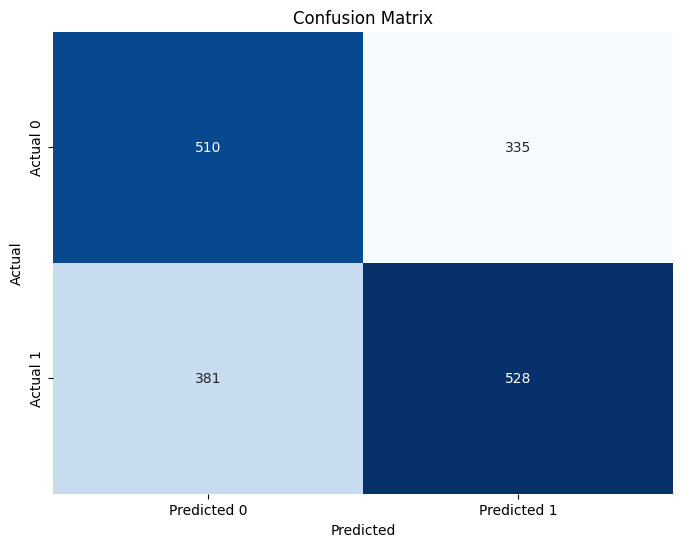

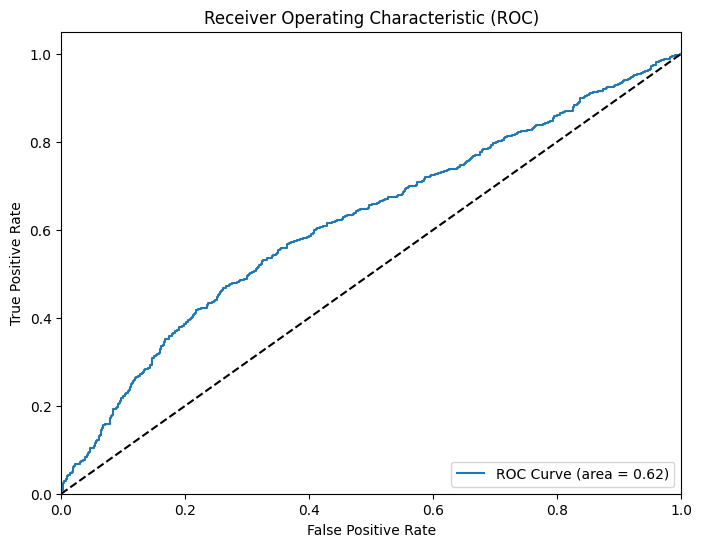

In [21]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

# Initialize the random forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Get the best model and its parameters
best_rf_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Feature Importance
feature_importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance_df)

# Make predictions on the test set
Y_pred = best_rf_model.predict(X_test)
Y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Classification Report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))


# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_train_VIF_check = X_train.copy()
X_train_VIF_check = X_train_VIF_check.drop(columns=[
    'constitution_Society', 'applicant_state', 'rec_basis_Cashflows', 'tenor',
    'total_income', 'coborrower1_cibilscore'
])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_VIF_check.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_VIF_check.values, i) for i in range(len(X_train_VIF_check.columns))]

vif_data.sort_values(by="VIF", ascending=False)

,feature,VIF
6,coborrower2_cibilscore,3.368156
9,coborrower2_designation_ordinal,3.001838
7,years_of_operation,2.947849
8,coborrower1_designation_ordinal,2.474484
5,applicant_city,2.290418
1,recomended_loan_amt,2.014278
19,locality_SEMIU,1.858427
18,product_Unsecured,1.796053
20,locality_URBAN,1.602506
13,constitution_Trust,1.578086
